In [21]:
import math, glob, time, os, re, json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from katrain.core.base_katrain import KaTrainBase
from katrain.core.game import Game, KaTrainSGF
from katrain.core.engine import KataGoEngine

In [2]:
kt = KaTrainBase()

Using user config file /home/sander/.katrain/config.json


In [84]:
e_config = kt.config("engine")
e_config["max_visits"] = e_config["fast_visits"] = 1  # since it's just policy anyway
e_config["threads"] = 64

In [86]:
engine = KataGoEngine(kt, e_config)

2020-06-11 10:51:13+0200: Analysis Engine starting...
2020-06-11 10:51:13+0200: KataGo v1.4.2+kt1.1 (minified)
2020-06-11 10:51:13+0200: nnRandSeed0 = 16258919693616980482
2020-06-11 10:51:13+0200: After dedups: nnModelFile0 = /home/sander/anaconda3/lib/python3.7/site-packages/katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz useFP16 auto useNHWC auto
2020-06-11 10:51:14+0200: Found OpenCL Platform 0: NVIDIA CUDA (NVIDIA Corporation) (OpenCL 1.2 CUDA 10.2.131)
2020-06-11 10:51:14+0200: Found 1 device(s) on platform 0 with type CPU or GPU or Accelerator
2020-06-11 10:51:14+0200: Found OpenCL Device 0: GeForce GTX 1050 Ti with Max-Q Design (NVIDIA Corporation) (score 11000102)
2020-06-11 10:51:14+0200: Using OpenCL Device 0: GeForce GTX 1050 Ti with Max-Q Design (NVIDIA Corporation) OpenCL 1.2 CUDA
2020-06-11 10:51:14+0200: Loaded tuning parameters from: /home/sander/.katrain/opencltuning/tune6_gpuGeForceGTX1050TiwithMaxQDesign_x19_y19_c192_mv8.txt
2020-06-11 10:51:14+0200: Note

In [109]:
PLAYERS={'W':'white','B':'black'}
def get_policy_stats(game):
    game.redo(999)
    moves = game.current_node.nodes_from_root[1:]  # without root
    while not all(m.analysis_ready for m in moves):
        time.sleep(0.01)

    parent_policy_per_move = [move.parent.policy_ranking for move in moves]
    num_legal_moves = [sum(pv >= 0 for pv, _ in policy_ranking) for policy_ranking in parent_policy_per_move]
    policy_stats = [
        [(move_num, num_mv, rank, value, policy_ranking[0][0], PLAYERS[mv.player]) for rank, (value, mv) in enumerate(policy_ranking) if mv == move.move][0]
        for move_num,(move, policy_ranking, num_mv) in enumerate(zip(moves, parent_policy_per_move, num_legal_moves))
    ]
    return policy_stats


def rank_to_kyu(r):
    return 30-r

In [133]:
games_data = pd.DataFrame(columns=['bot','bot_rank','user','user_rank','user_color','winner','outcome'])
moves_data = []


for filename in tqdm(glob.glob("sgf_ogs/*.sgf")):
    sgf = KaTrainSGF.parse_file(filename)

    gamedata_str = re.search('Gamedata:(.*)SGF with review',sgf.properties['C'][0],re.DOTALL)[1]
    gamedata = json.loads(gamedata_str)
    outcome = gamedata['outcome']
    rank = {p:rank_to_kyu(gamedata['players'][p]['rank']) for p in ['white','black']}
    players = {p:gamedata['players'][p]['username'] for p in ['white','black']}
    ids = {p:gamedata['players'][p]['id'] for p in ['white','black']}
    bot_player = 'black' if 'katrain-' in players['black'] else 'white'
    non_bot_player = 'black' if bot_player=='white' else 'white'
    winner = 'black' if gamedata['winner']==ids['black'] else 'white'
    gameid = gamedata['game_id']

    if outcome == 'Cancellation' or sgf.board_size!=(19,19) or not gamedata['ranked']:
        continue

    try:
        move_analysis =  [ (gameid,*stats,non_bot_player) for stats in get_policy_stats(game) ] 
    except:
        print(f"Error in analyzing {filename}") # branching etc
        continue
        
    games_data.loc[gameid] = (players[bot_player],rank[bot_player],
                          players[non_bot_player],rank[non_bot_player],non_bot_player,
                          winner,outcome)
    game = Game(kt, engine, move_tree=sgf)
    moves_data.append(move_analysis)
    
moves_data = pd.DataFrame( sum(moves_data,[]),    
    columns=['game_id','move','num_legal','policy_rank','policy_value','top_value','move_color','user_color'])    

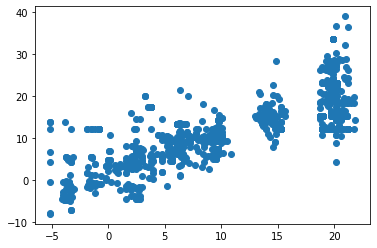

In [135]:
plt.scatter(df.bot_rank,df.user_rank)

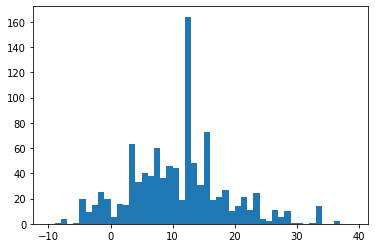

In [136]:
plt.hist(df.user_rank,bins=range(-10,40));

In [150]:
user_moves = moves_data[moves_data.move_color==moves_data.user_color]
user_moves['rank'] = games_data.loc[user_moves.game_id].user_rank.values

In [162]:
rank_stats = [(r,df.policy_rank.mean(),df.policy_rank.median(),df.shape[0]) for r,df in user_moves.groupby(user_moves['rank'].round())]

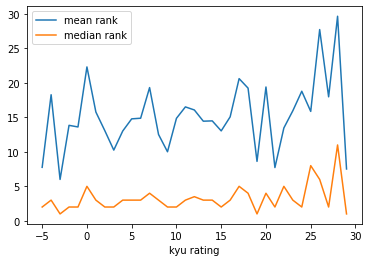

In [163]:
rank, mean, median, sample_size = zip(*rank_stats)
plt.plot(rank,mean,rank,median)
plt.xlabel('kyu rating')
plt.legend(['mean rank','median rank'])